# Problem Statement

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase. The task in hand is to identify fraudulent credit card transactions.

The datasets contains transactions made by credit cards in September 2013 by european cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

### Input Variables

Time: Number of seconds elapsed between this transaction and the first transaction in the dataset

V1-V28: may be result of a PCA Dimensionality reduction to protect user identities and sensitive features(v1-v28)

Amount: Transaction amount

### Target Variable

Class: 1 for fraudulent transactions, 0 otherwise

# Solution

As all except two of the input variables are uninterpretable, there is not much scope for feature engineering. We are going to compute the difference in time between transactions from the 'Time' variable for some preliminary analysis, but won't be using it as an input in our final model. We will standardize all of the input variables before feeding them to the model. The data will then be divided into train, validation and test sets.

To address the large imbalance of classes, we will be using ADASYN (Adaptive Synthetic sampling) to create synthetic data from 10 nearest neighbors of each point of the minority class. As the ratio of imbalance is large, we will be oversampling the minority class to one-tenth of the minority class for training purpose. We will rely on the model 'class_weight' property to handle the reduced imbalance of the dataset.

We will be using a Random Forest Classifier, a k-Nearest Neighbor Classifier and a Neural Network-based Classifier as our credit card fraud detector, and will be using the area under precision-recall curve as the metric for measuring model performance.

### Importing relevant libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf

from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_curve, auc
from sklearn.model_selection import GridSearchCV

C:\Software\Anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Importing Data

In [2]:
raw_data = pd.read_csv('.../creditcard.csv')
raw_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Data Description

In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

#### We see that the dataset has no missing values, and all input variables are numeric.

In [4]:
raw_data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [5]:
# creating a savepoint

data = raw_data.copy()

### Data Preprocessing

In [6]:
data.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

#### This confirms the large imbalance of classes in the dataset.

In [7]:
# creating variable 'Time_Diff' denoting time difference between transactions

data['Time_Diff'] = data.Time.diff()
data.loc[0, 'Time_Diff'] = 0
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Time_Diff
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,1.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,1.0


In [8]:
# removing the 'Time' variable from our data

data.drop('Time', axis=1, inplace=True)
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Time_Diff
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,1.0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,1.0


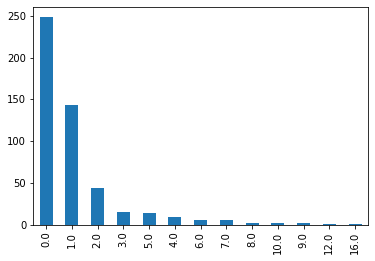

In [9]:
data[data.Class == 1].Time_Diff.value_counts().plot.bar()

#### This shows that roughly half the fraudulent transactions occured simultaneously (on the seconds scale) with a non-fraudulent one.

In [10]:
len(data[data.Amount == 0.0])

1825

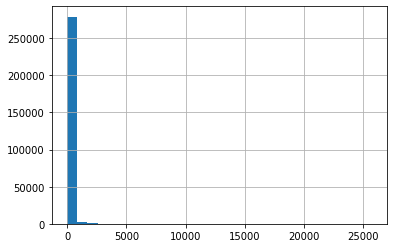

In [11]:
data[data.Amount != 0].Amount.hist(bins=30)

In [12]:
# correlation between input variables

corr = data.drop(['Class'], axis=1).corr()
corr

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Time_Diff
V1,1.000000e+00,4.697350e-17,-1.424390e-15,1.755316e-17,6.391162e-17,2.398071e-16,1.991550e-15,-9.490675e-17,2.169581e-16,7.433820e-17,...,-1.755072e-16,7.477367e-17,9.808705e-16,7.354269e-17,-9.805358e-16,-8.621897e-17,3.208233e-17,9.820892e-16,-0.227709,-0.008074
V2,4.697350e-17,1.000000e+00,2.512175e-16,-1.126388e-16,-2.039868e-16,5.024680e-16,3.966486e-16,-4.413984e-17,-5.728718e-17,-4.782388e-16,...,8.444409e-17,2.500830e-16,1.059562e-16,-8.142354e-18,-4.261894e-17,2.601622e-16,-4.478472e-16,-3.676415e-16,-0.531409,0.024858
V3,-1.424390e-15,2.512175e-16,1.000000e+00,-3.416910e-16,-1.436514e-15,1.431581e-15,2.168574e-15,3.433113e-16,-4.233770e-16,6.289267e-16,...,-2.971969e-17,4.648259e-16,2.115206e-17,-9.351637e-17,4.771164e-16,6.521501e-16,6.239832e-16,7.726948e-16,-0.210880,0.019989
V4,1.755316e-17,-1.126388e-16,-3.416910e-16,1.000000e+00,-1.940929e-15,-2.712659e-16,1.556330e-16,5.195643e-16,3.859585e-16,6.055490e-16,...,-9.976950e-17,2.099922e-16,6.002528e-17,2.229738e-16,5.394585e-16,-6.179751e-16,-6.403423e-17,-5.863664e-17,0.098732,0.039772
V5,6.391162e-17,-2.039868e-16,-1.436514e-15,-1.940929e-15,1.000000e+00,7.926364e-16,-4.209851e-16,7.589187e-16,4.205206e-16,-6.601716e-16,...,-1.368701e-16,5.060029e-16,1.637596e-16,-9.286095e-16,5.625102e-16,9.144690e-16,4.465960e-16,-3.299167e-16,-0.386356,0.020337
V6,2.398071e-16,5.024680e-16,1.431581e-15,-2.712659e-16,7.926364e-16,1.000000e+00,1.429426e-16,-1.707421e-16,1.114447e-16,2.850776e-16,...,-1.575903e-16,-3.362902e-16,-7.232186e-17,-1.261867e-15,1.081933e-15,-2.378414e-16,-2.623818e-16,4.813155e-16,0.215981,0.007611
V7,1.991550e-15,3.966486e-16,2.168574e-15,1.556330e-16,-4.209851e-16,1.429426e-16,1.000000e+00,-8.691834e-17,7.933251e-16,3.043333e-17,...,1.938604e-16,-1.058131e-15,2.327911e-16,-2.589727e-17,1.174169e-15,-7.334507e-16,-5.886825e-16,-6.836764e-17,0.397311,-0.002922
V8,-9.490675e-17,-4.413984e-17,3.433113e-16,5.195643e-16,7.589187e-16,-1.707421e-16,-8.691834e-17,1.000000e+00,2.900829e-16,9.051847e-17,...,-2.412439e-16,5.475559e-16,3.897104e-16,-1.802967e-16,-1.390791e-16,-1.209975e-16,1.733633e-16,-4.484325e-16,-0.103079,-0.011406
V9,2.169581e-16,-5.728718e-17,-4.233770e-16,3.859585e-16,4.205206e-16,1.114447e-16,7.933251e-16,2.900829e-16,1.000000e+00,-2.771761e-16,...,4.578389e-17,2.871855e-17,5.929286e-16,-2.346385e-16,1.099645e-15,-1.388725e-15,-2.287414e-16,9.146779e-16,-0.044246,0.144383
V10,7.433820e-17,-4.782388e-16,6.289267e-16,6.055490e-16,-6.601716e-16,2.850776e-16,3.043333e-17,9.051847e-17,-2.771761e-16,1.000000e+00,...,8.089504e-16,-6.707598e-16,3.809732e-16,-4.032806e-17,-2.863813e-16,-2.554293e-16,-3.103239e-16,-1.515934e-16,-0.101502,-0.045864


In [13]:
# checking for input variables with high correlation

for i in range(corr.shape[0]):
    for j in range(i, corr.shape[1]):
        if np.abs(corr.iloc[i,j] > 0.4) and i!=j:
            print(i,j)

#### We see that none of the input variables are highly correlated with each other.

In [14]:
# standardizing input variables

cols_list = list(data.columns)[:-2]

scaler = StandardScaler()
data[cols_list] = scaler.fit_transform(data[cols_list])
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Time_Diff
0,-0.694242,-0.044075,1.672773,0.973366,-0.245117,0.347068,0.193679,0.082637,0.331128,0.083386,...,0.382854,-0.176911,0.110507,0.246585,-0.392170,0.330892,-0.063781,0.244964,0,0.0
1,0.608496,0.161176,0.109797,0.316523,0.043483,-0.061820,-0.063700,0.071253,-0.232494,-0.153350,...,-0.880077,0.162201,-0.561131,0.320694,0.261069,-0.022256,0.044608,-0.342475,0,0.0
2,-0.693500,-0.811578,1.169468,0.268231,-0.364572,1.351454,0.639776,0.207373,-1.378675,0.190700,...,1.063358,1.456320,-1.138092,-0.628537,-0.288447,-0.137137,-0.181021,1.160686,0,1.0
3,-0.493325,-0.112169,1.182516,-0.609727,-0.007469,0.936150,0.192071,0.316018,-1.262503,-0.050468,...,0.007267,-0.304777,-1.941027,1.241904,-0.460217,0.155396,0.186189,0.140534,0,0.0
4,-0.591330,0.531541,1.021412,0.284655,-0.295015,0.071999,0.479302,-0.226510,0.744326,0.691625,...,1.100011,-0.220123,0.233250,-0.395202,1.041611,0.543620,0.651816,-0.073403,0,1.0


In [15]:
# separating the input and target variables

X = data.drop(['Time_Diff','Class'], axis=1)
y = data.Class

In [16]:
# dividing the data into train, validation and test sets

X_train, X_valandtest, y_train, y_valandtest = train_test_split(X, y, test_size=0.2, random_state=7)
X_val, X_test, y_val, y_test = train_test_split(X_valandtest, y_valandtest, test_size=0.5, random_state=8)

In [17]:
# checking class balance in train, validation and test sets.

print(np.bincount(y_train),'\n',np.bincount(y_val),'\n',np.bincount(y_test))

[227453    392] 
 [28434    47] 
 [28428    53]


In [18]:
# oversampling the training set to address class imbalance

adasyn = ADASYN(ratio=0.1, n_neighbors=10, random_state=9)
X_train_bal, y_train_bal = adasyn.fit_sample(X_train,y_train)

C:\Software\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [19]:
# checking class balance in training set

np.bincount(y_train_bal)

array([227453,  22779], dtype=int64)

### Random Forest Classifier

In [20]:
rfc = RandomForestClassifier(class_weight='balanced', random_state=10)
rfc.fit(X_train_bal, y_train_bal)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=10,
            verbose=0, warm_start=False)

In [21]:
y_pred = rfc.predict(X_val)
y_pred_probs = rfc.predict_proba(X_val)[:, 1]

cnf_mt = confusion_matrix(y_val, y_pred)
prec, rec, _ = precision_recall_curve(y_val, y_pred_probs)
auc_pr = auc(rec, prec)
acc = accuracy_score(y_val, y_pred)

print('Confusion Matrix: \n',cnf_mt,'\n\nArea under PR curve: ', auc_pr, '\n\nAccuracy: ', acc)

Confusion Matrix: 
 [[28423    11]
 [    5    42]] 

Area under PR curve:  0.8410532763648622 

Accuracy:  0.9994382219725431


In [22]:
# using grid search to find optimal parameter set with scoring set to 'average_precision'
# as it is a close approximation of area under precision-recall curve

params = {'n_estimators': [10,25,50], 
          'max_depth': [2,5,10], 
          'max_features': [2,8,'auto']}

gridsearch = GridSearchCV(rfc, param_grid=params, cv=5, scoring='average_precision', n_jobs=2)
gridsearch.fit(X_train_bal,y_train_bal)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=10,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'n_estimators': [10, 25, 50], 'max_depth': [2, 5, 10], 'max_features': [2, 8, 'auto']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='average_precision', verbose=0)

In [23]:
print(gridsearch.best_estimator_,'\n\n',gridsearch.best_score_)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features=8,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=10,
            verbose=0, warm_start=False) 

 0.8414549487012356


In [24]:
rfc = RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=8, n_estimators=50, random_state=11)
rfc.fit(X_train_bal, y_train_bal)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features=8,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=11,
            verbose=0, warm_start=False)

In [25]:
y_pred = rfc.predict(X_val)
y_pred_probs = rfc.predict_proba(X_val)[:, 1]

cnf_mt = confusion_matrix(y_val, y_pred)
prec, rec, _ = precision_recall_curve(y_val, y_pred_probs)
auc_pr = auc(rec, prec)
acc = accuracy_score(y_val, y_pred)

print('Confusion Matrix: \n',cnf_mt,'\n\nArea under PR curve: ', auc_pr, '\n\nAccuracy: ', acc)

Confusion Matrix: 
 [[27632   802]
 [    4    43]] 

Area under PR curve:  0.8154126657937484 

Accuracy:  0.9717004318668586


In [26]:
rfc = RandomForestClassifier(class_weight='balanced', max_depth=5, max_features=8, n_estimators=100, random_state=12)
rfc.fit(X_train_bal, y_train_bal)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features=8,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=12,
            verbose=0, warm_start=False)

In [27]:
y_pred = rfc.predict(X_val)
y_pred_probs = rfc.predict_proba(X_val)[:, 1]

cnf_mt = confusion_matrix(y_val, y_pred)
prec, rec, _ = precision_recall_curve(y_val, y_pred_probs)
auc_pr = auc(rec, prec)
acc = accuracy_score(y_val, y_pred)

print('Confusion Matrix: \n',cnf_mt,'\n\nArea under PR curve: ', auc_pr, '\n\nAccuracy: ', acc)

Confusion Matrix: 
 [[26716  1718]
 [    3    44]] 

Area under PR curve:  0.845865292180593 

Accuracy:  0.9395737509216671


In [28]:
rfc = RandomForestClassifier(class_weight='balanced', max_depth=5, max_features=8, n_estimators=20, random_state=13)
rfc.fit(X_train_bal, y_train_bal)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features=8,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=13,
            verbose=0, warm_start=False)

In [29]:
y_pred = rfc.predict(X_val)
y_pred_probs = rfc.predict_proba(X_val)[:, 1]

cnf_mt = confusion_matrix(y_val, y_pred)
prec, rec, _ = precision_recall_curve(y_val, y_pred_probs)
auc_pr = auc(rec, prec)
acc = accuracy_score(y_val, y_pred)

print('Confusion Matrix: \n',cnf_mt,'\n\nArea under PR curve: ', auc_pr, '\n\nAccuracy: ', acc)

Confusion Matrix: 
 [[26602  1832]
 [    4    43]] 

Area under PR curve:  0.723532641764517 

Accuracy:  0.9355359713493206


In [30]:
# predictions on the test set

rfc = RandomForestClassifier(class_weight='balanced', max_depth=5, max_features=8, n_estimators=100, random_state=12)
rfc.fit(X_train_bal, y_train_bal)

y_pred = rfc.predict(X_test)
y_pred_probs = rfc.predict_proba(X_test)[:, 1]

cnf_mt = confusion_matrix(y_test, y_pred)
prec, rec, _ = precision_recall_curve(y_test, y_pred_probs)
auc_pr = auc(rec, prec)
acc = accuracy_score(y_test, y_pred)

print('Confusion Matrix: \n',cnf_mt,'\n\nArea under PR curve: ', auc_pr, '\n\nAccuracy: ', acc)

Confusion Matrix: 
 [[26727  1701]
 [    2    51]] 

Area under PR curve:  0.7236615717937276 

Accuracy:  0.9402057512025561


#### The final Random Forest Classifier (with parameter set {'class_weight':'balanced', 'max_depth':5, 'max_features':8, 'n_estimators':100}) correctly detects 51/53 of the fraudulent transactions. However it manages to mistake around 6% of the non-fraudulent transactions as fraudulent.

### k-Nearest Neighbors Classifier

In [31]:
knn = KNeighborsClassifier()
knn.fit(X_train_bal, y_train_bal)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [32]:
y_pred = knn.predict(X_val)
y_pred_probs = knn.predict_proba(X_val)[:, 1]

cnf_mt = confusion_matrix(y_val, y_pred)
prec, rec, _ = precision_recall_curve(y_val, y_pred_probs)
auc_pr = auc(rec, prec)
acc = accuracy_score(y_val, y_pred)

print('Confusion Matrix: \n',cnf_mt,'\n\nArea under PR curve: ', auc_pr, '\n\nAccuracy: ', acc)

Confusion Matrix: 
 [[28329   105]
 [    4    43]] 

Area under PR curve:  0.7363794062480453 

Accuracy:  0.9961728871879498


In [33]:
knn = KNeighborsClassifier(n_neighbors=7, weights='distance')
knn.fit(X_train_bal, y_train_bal)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='distance')

In [34]:
y_pred = knn.predict(X_val)
y_pred_probs = knn.predict_proba(X_val)[:, 1]

cnf_mt = confusion_matrix(y_val, y_pred)
prec, rec, _ = precision_recall_curve(y_val, y_pred_probs)
auc_pr = auc(rec, prec)
acc = accuracy_score(y_val, y_pred)

print('Confusion Matrix: \n',cnf_mt,'\n\nArea under PR curve: ', auc_pr, '\n\nAccuracy: ', acc)

Confusion Matrix: 
 [[28310   124]
 [    4    43]] 

Area under PR curve:  0.7643615252701048 

Accuracy:  0.9955057757803448


In [35]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train_bal, y_train_bal)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

In [36]:
y_pred = knn.predict(X_val)
y_pred_probs = knn.predict_proba(X_val)[:, 1]

cnf_mt = confusion_matrix(y_val, y_pred)
prec, rec, _ = precision_recall_curve(y_val, y_pred_probs)
auc_pr = auc(rec, prec)
acc = accuracy_score(y_val, y_pred)

print('Confusion Matrix: \n',cnf_mt,'\n\nArea under PR curve: ', auc_pr, '\n\nAccuracy: ', acc)

Confusion Matrix: 
 [[28300   134]
 [    4    43]] 

Area under PR curve:  0.7883584869356807 

Accuracy:  0.9951546645131842


In [37]:
# predictions on the test set

knn = KNeighborsClassifier()
knn.fit(X_train_bal, y_train_bal)

y_pred = knn.predict(X_test)
y_pred_probs = knn.predict_proba(X_test)[:, 1]

cnf_mt = confusion_matrix(y_test, y_pred)
prec, rec, _ = precision_recall_curve(y_test, y_pred_probs)
auc_pr = auc(rec, prec)
acc = accuracy_score(y_test, y_pred)

print('Confusion Matrix: \n',cnf_mt,'\n\nArea under PR curve: ', auc_pr, '\n\nAccuracy: ', acc)

Confusion Matrix: 
 [[28331    97]
 [    9    44]] 

Area under PR curve:  0.7044731636558972 

Accuracy:  0.996278220568098


#### The final k-Nearest Neighbors Classifier (with the default Scikit Learn parameter set) correctly detects 44/53 of the fraudulent transactions. However it manages to mistake around 0.3% of the non-fraudulent transactions as fraudulent.

### Neural Network-based Classifier

In [38]:
# creating the network structure

hidden_layer_size = [64,32,8]
output_size = 2

model = tf.keras.Sequential([
        
    tf.keras.layers.Dense(hidden_layer_size[0], activation='relu', input_shape=(X_train_bal.shape[1],)),
    tf.keras.layers.Dense(hidden_layer_size[1], activation='relu'),
    tf.keras.layers.Dense(hidden_layer_size[2], activation='relu'),
    
    tf.keras.layers.Dense(output_size, activation='softmax')
])

# checking model structure and no. of parameters

model.summary()

cls_wt = {0: 1, 1: 10}

#compiling and fitting the model

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_bal, y_train_bal, epochs=10, class_weight=cls_wt, verbose=2)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1920      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 18        
Total params: 4,282
Trainable params: 4,282
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
250232/250232 - 12s - loss: 0.2534 - acc: 0.9554
Epoch 2/10
250232/250232 - 11s - loss: 0.1083 - acc: 0.9824
Epoch 3/10
250

In [39]:
y_pred = model.predict_classes(X_val)
y_pred_probs = model.predict(X_val)[:, 1]

cnf_mt = confusion_matrix(y_val, y_pred)
prec, rec, _ = precision_recall_curve(y_val, y_pred_probs)
auc_pr = auc(rec, prec)
acc = accuracy_score(y_val, y_pred)

print('Confusion Matrix: \n',cnf_mt,'\n\nArea under PR curve: ', auc_pr, '\n\nAccuracy: ', acc)

Confusion Matrix: 
 [[28272   162]
 [    5    42]] 

Area under PR curve:  0.7724966620197126 

Accuracy:  0.9941364418384186


In [40]:
hidden_layer_size = [64,32,8]
output_size = 2

model = tf.keras.Sequential([
        
    tf.keras.layers.Dense(hidden_layer_size[0], activation='relu', input_shape=(X_train_bal.shape[1],)),
    tf.keras.layers.Dense(hidden_layer_size[1], activation='relu'),
    tf.keras.layers.Dense(hidden_layer_size[2], activation='relu'),
    
    tf.keras.layers.Dense(output_size, activation='softmax')
])

model.summary()

cls_wt = {0: 1, 1: 8}

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_bal, y_train_bal, epochs=10, class_weight=cls_wt, verbose=2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                1920      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 18        
Total params: 4,282
Trainable params: 4,282
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
250232/250232 - 12s - loss: 0.2452 - acc: 0.9564
Epoch 2/10
250232/250232 - 12s - loss: 0.0991 - acc: 0.9825
Epoch 3/10
250232/250232 - 11s - loss: 0.0758 - acc: 0.9867
Epoch 4/10
250232/250232 - 11s - loss: 0.0623 - acc: 0.9888
Epoch 5/10

In [41]:
y_pred = model.predict_classes(X_val)
y_pred_probs = model.predict(X_val)[:, 1]

cnf_mt = confusion_matrix(y_val, y_pred)
prec, rec, _ = precision_recall_curve(y_val, y_pred_probs)
auc_pr = auc(rec, prec)
acc = accuracy_score(y_val, y_pred)

print('Confusion Matrix: \n',cnf_mt,'\n\nArea under PR curve: ', auc_pr, '\n\nAccuracy: ', acc)

Confusion Matrix: 
 [[28089   345]
 [    5    42]] 

Area under PR curve:  0.6947990897050854 

Accuracy:  0.9877111056493802


In [42]:
hidden_layer_size = [50,100,75,25,8]
output_size = 2

model = tf.keras.Sequential([
        
    tf.keras.layers.Dense(hidden_layer_size[0], activation='relu', input_shape=(X_train_bal.shape[1],)),
    tf.keras.layers.Dense(hidden_layer_size[1], activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(hidden_layer_size[2], activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(hidden_layer_size[3], activation='relu'),
    tf.keras.layers.Dense(hidden_layer_size[4], activation='relu'),
    
    tf.keras.layers.Dense(output_size, activation='softmax')
])

model.summary()

cls_wt = {0: 1, 1: 10}

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_bal, y_train_bal, epochs=10, class_weight=cls_wt, verbose=2)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 50)                1500      
_________________________________________________________________
dense_9 (Dense)              (None, 100)               5100      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 75)                7575      
_________________________________________________________________
dropout_1 (Dropout)          (None, 75)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 25)                1900      
_________________________________________________________________
dense_12 (Dense)             (None, 8)                

In [43]:
y_pred = model.predict_classes(X_val)
y_pred_probs = model.predict(X_val)[:, 1]

cnf_mt = confusion_matrix(y_val, y_pred)
prec, rec, _ = precision_recall_curve(y_val, y_pred_probs)
auc_pr = auc(rec, prec)
acc = accuracy_score(y_val, y_pred)

print('Confusion Matrix: \n',cnf_mt,'\n\nArea under PR curve: ', auc_pr, '\n\nAccuracy: ', acc)

Confusion Matrix: 
 [[28179   255]
 [    5    42]] 

Area under PR curve:  0.6092607736354932 

Accuracy:  0.9908711070538253


In [44]:
hidden_layer_size = [64,32,8]
output_size = 2

model = tf.keras.Sequential([
        
    tf.keras.layers.Dense(hidden_layer_size[0], activation='relu', input_shape=(X_train_bal.shape[1],)),
    tf.keras.layers.Dense(hidden_layer_size[1], activation='relu'),
    tf.keras.layers.Dense(hidden_layer_size[2], activation='relu'),
    
    tf.keras.layers.Dense(output_size, activation='softmax')
])

model.summary()

cls_wt = {0: 1, 1: 12}

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_bal, y_train_bal, epochs=15, class_weight=cls_wt, verbose=2)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 64)                1920      
_________________________________________________________________
dense_15 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 18        
Total params: 4,282
Trainable params: 4,282
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
250232/250232 - 12s - loss: 0.2902 - acc: 0.9469
Epoch 2/15
250232/250232 - 12s - loss: 0.1166 - acc: 0.9812
Epoch 3/15
250232/250232 - 12s - loss: 0.0884 - acc: 0.9859
Epoch 4/15
250232/250232 - 12s - loss: 0.0775 - acc: 0.9879
Epoch 5/15

In [45]:
y_pred = model.predict_classes(X_val)
y_pred_probs = model.predict(X_val)[:, 1]

cnf_mt = confusion_matrix(y_val, y_pred)
prec, rec, _ = precision_recall_curve(y_val, y_pred_probs)
auc_pr = auc(rec, prec)
acc = accuracy_score(y_val, y_pred)

print('Confusion Matrix: \n',cnf_mt,'\n\nArea under PR curve: ', auc_pr, '\n\nAccuracy: ', acc)

Confusion Matrix: 
 [[28286   148]
 [    5    42]] 

Area under PR curve:  0.5053338301685529 

Accuracy:  0.9946279976124434


#### Since neural networks are stochastic in nature, the results vary with every run. The model yielding best results was saved, and its performance on the test set is shown below.

In [46]:
# predictions on the test set

model = tf.keras.models.load_model('.../CreditCardFraud_NN.h5')

y_pred = model.predict_classes(X_test)
y_pred_probs = model.predict(X_test)[:, 1]

cnf_mt = confusion_matrix(y_test, y_pred)
prec, rec, _ = precision_recall_curve(y_test, y_pred_probs)
auc_pr = auc(rec, prec)
acc = accuracy_score(y_test, y_pred)

print('Confusion Matrix: \n',cnf_mt,'\n\nArea under PR curve: ', auc_pr, '\n\nAccuracy: ', acc)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Confusion Matrix: 
 [[28066   362]
 [    8    45]] 

Area under PR curve:  0.7778394349088651 

Accuracy:  0.9870088831150592


#### The final Neural Network-based Classifier (saved as 'CreditCardFraud_NN.h5') correctly detects 45/53 of the fraudulent transactions. However it manages to mistake around 1% of the non-fraudulent transactions as fraudulent.

# Remarks

Based on the data provided, all the three models detected more than 80% of the fraudulent transactions.

While the Random Forest Classifier manages to detect more than 95% of the fraudulent transactions, but it also misclassifies many proper transactions as fraudulent. The other two models do not do that well in detecting fraudulent transactions, but they have a significantly low misclassification rate. 

In this case, the bank can decide which model would suit them better. On a personal note, I would prefer the Random Forest Classifier. The transactions misclassified as fraudulent can be verified to be correct by the transaction initiator, and it is necessary to verify suspicious transactions even though it may cause minor inconvenience to the client.